# Serrodyne Modulation with Electro-Optic Modulators

$$E_{in}(t) = E_0 \cos(\omega_c t)$$

the EOM output becomes:

$$E_{out}(t) = E_0 \cos(\omega_c t + \phi(t))$$

where $\phi(t) = \frac{\pi V(t)}{V_\pi}$ is the phase shift proportional to the applied voltage. The voltage $V_\pi$ is the half-wave voltage — the voltage required for a $\pi$ phase shift.

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import jn
from scipy.signal import sawtooth

In [76]:
# Utility functions for visualization
def plot_time_domain(t, signals, labels=None, title="Time Domain Signal", xlabel="Time [s]", ylabel="Amplitude"):
    """Plot one or more signals in the time domain."""
    plt.figure(figsize=(12, 4))
    if not isinstance(signals, list):
        signals = [signals]
    for i, signal in enumerate(signals):
        label = labels[i] if labels else None
        plt.plot(t, signal, label=label, linewidth=1.5)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True, alpha=0.3)
    if labels:
        plt.legend()
    plt.tight_layout()
    plt.show()

def plot_fft(signal, sample_rate, title="Frequency Spectrum", xlim=None, show_peak=True):
    """Plot the magnitude spectrum of a signal."""
    N = len(signal)
    fft_values = np.fft.fft(signal)
    freq = np.fft.fftshift(np.fft.fftfreq(N, 1/sample_rate))
    magnitude = np.fft.fftshift(np.abs(fft_values)) / N  # Normalize
    
    plt.figure(figsize=(12, 4))
    plt.plot(freq, magnitude, linewidth=1)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Magnitude (normalized)')
    plt.title(title)
    plt.grid(True, alpha=0.3)
    if xlim:
        plt.xlim(xlim)
    plt.tight_layout()
    
    if show_peak:
        peak_idx = np.argmax(magnitude)
        print(f"Peak: {freq[peak_idx]:.2f} Hz, Magnitude: {magnitude[peak_idx]:.4f}")
    plt.show()
    return freq, magnitude

When the modulation voltage is sinusoidal:
$$\phi(t) = \beta \sin(\omega_m t)$$

where $\beta$ is the **modulation index** (or modulation depth), the output field becomes:

$$E_{out}(t) = E_0 \cos(\omega_c t + \beta \sin(\omega_m t))$$

Using the Jacobi-Anger expansion, this can be written as a sum of sidebands:

$$E_{out}(t) = E_0 \sum_{n=-\infty}^{\infty} J_n(\beta) \cos((\omega_c + n\omega_m)t)$$

where $J_n(\beta)$ are **Bessel functions of the first kind**. Key observations:
- Sidebands appear at $\omega_c \pm n\omega_m$ for all integers $n$
- Sidebands are **symmetric** around the carrier
- The amplitude of the $n$-th sideband is proportional to $J_n(\beta)$

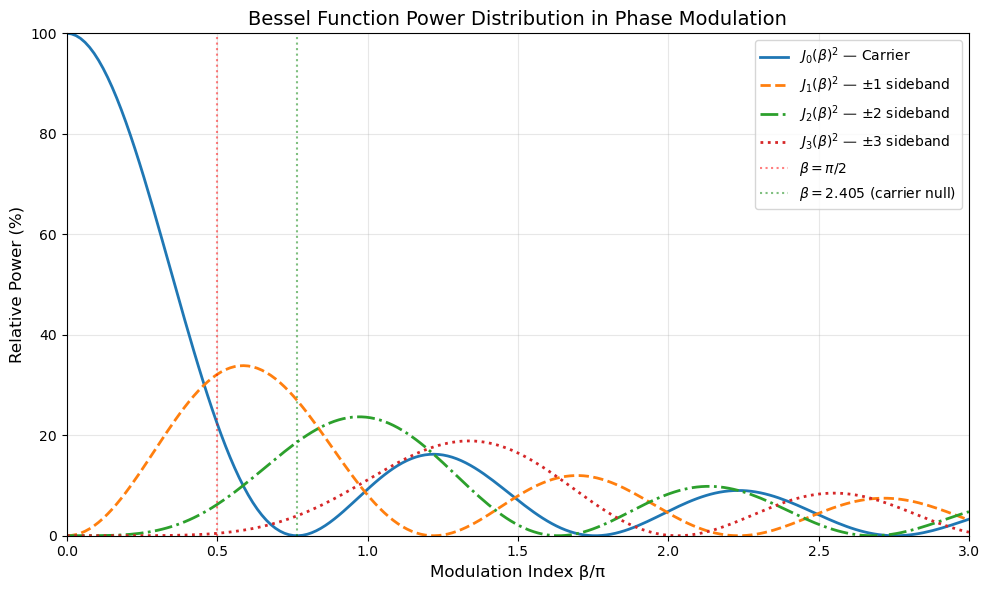

Notable modulation indices:
  β = π/2 ≈ 1.571: J₀² = 22.3%, J₁² = 32.1%
  β = 2.405: J₀² = 0.0% (carrier null), J₁² = 26.9%
  β = π ≈ 3.142: J₀² = 9.3%, J₁² = 8.1%


In [73]:
# Bessel function power distribution vs modulation index
beta_vals = np.linspace(0, 3*np.pi, 200)

plt.figure(figsize=(10, 6))
for n, style in [(0, '-'), (1, '--'), (2, '-.'), (3, ':')]:
    power = jn(n, beta_vals)**2 * 100
    label = f'$J_{n}(\\beta)^2$ — {"Carrier" if n==0 else f"±{n} sideband"}'
    plt.plot(beta_vals/np.pi, power, style, linewidth=2, label=label)

plt.axvline(x=0.5, color='red', linestyle=':', alpha=0.5, label='$\\beta = \\pi/2$')
plt.axvline(x=2.405/np.pi, color='green', linestyle=':', alpha=0.5, label='$\\beta = 2.405$ (carrier null)')

plt.xlabel('Modulation Index β/π', fontsize=12)
plt.ylabel('Relative Power (%)', fontsize=12)
plt.title('Bessel Function Power Distribution in Phase Modulation', fontsize=14)
plt.xlim(0, 3)
plt.ylim(0, 100)
plt.grid(True, alpha=0.3)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

print("Notable modulation indices:")
print(f"  β = π/2 ≈ {np.pi/2:.3f}: J₀² = {jn(0,np.pi/2)**2*100:.1f}%, J₁² = {jn(1,np.pi/2)**2*100:.1f}%")
print(f"  β = 2.405: J₀² = {jn(0,2.405)**2*100:.1f}% (carrier null), J₁² = {jn(1,2.405)**2*100:.1f}%")
print(f"  β = π ≈ {np.pi:.3f}: J₀² = {jn(0,np.pi)**2*100:.1f}%, J₁² = {jn(1,np.pi)**2*100:.1f}%")

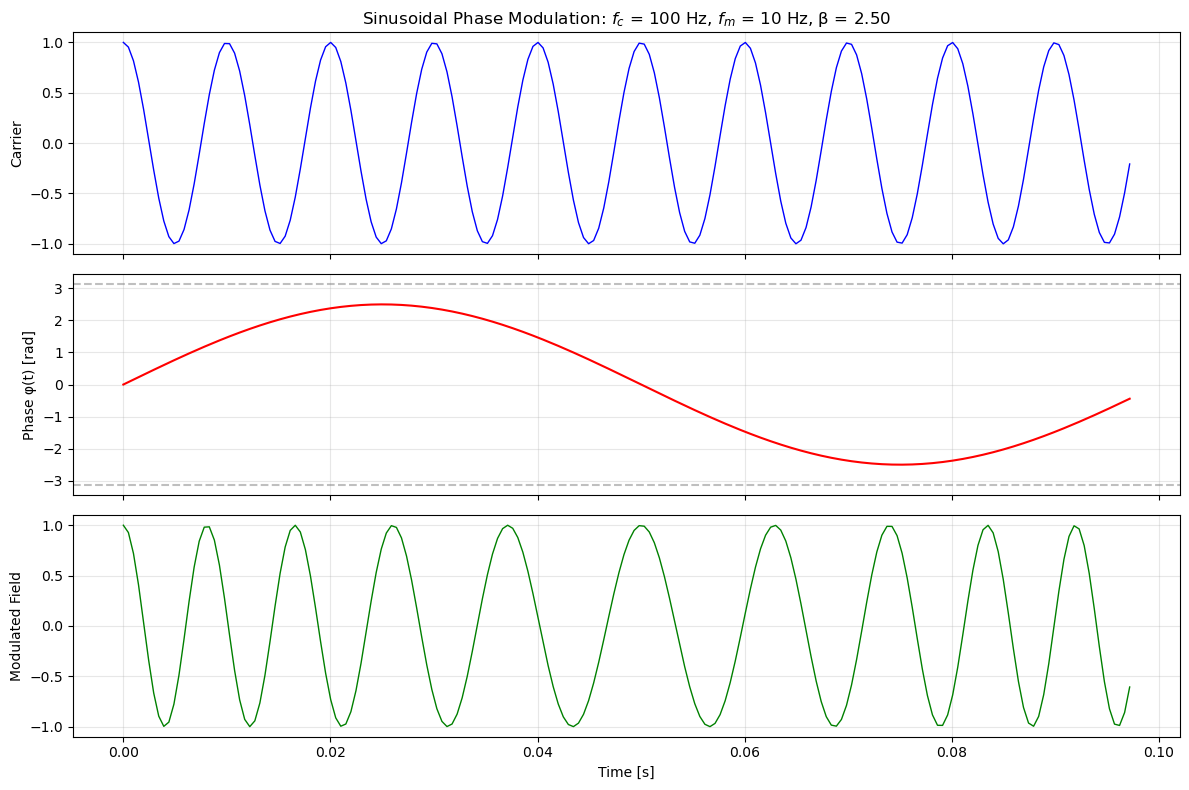

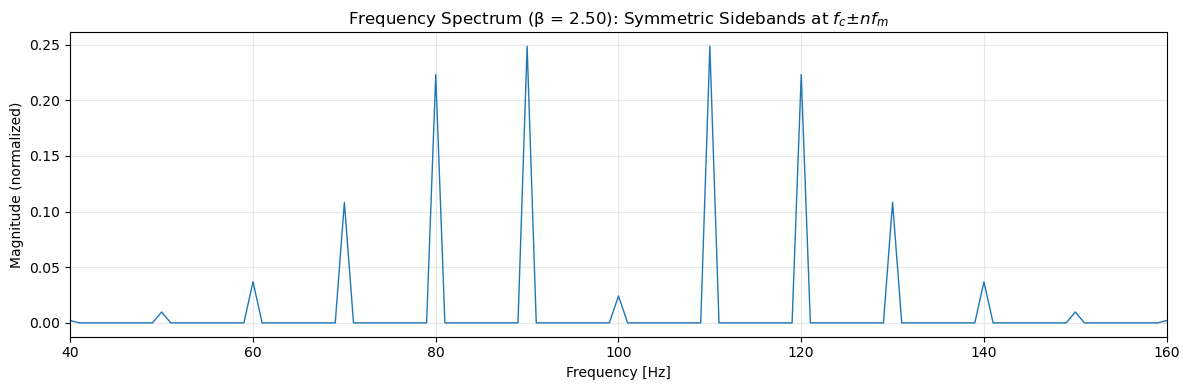


Expected sideband frequencies: 100 ± n×10 Hz
  n=0: 100 Hz and 100 Hz, relative amplitude J_0(2.50) = -0.0484
  n=1: 90 Hz and 110 Hz, relative amplitude J_1(2.50) = 0.4971
  n=2: 80 Hz and 120 Hz, relative amplitude J_2(2.50) = 0.4461
  n=3: 70 Hz and 130 Hz, relative amplitude J_3(2.50) = 0.2166
  n=4: 60 Hz and 140 Hz, relative amplitude J_4(2.50) = 0.0738


In [74]:
# Simulation parameters
fs = 2048           # Sampling rate [Hz]
N = 2048            # Number of samples (1 second duration)
t = np.arange(N) / fs  # Time array

# Signal parameters
f_c = 100           # Carrier frequency [Hz]
f_m = 10            # Modulation frequency [Hz]
beta = 2.5          # Modulation index (try: π/2, 2.405, π, 5)

# Generate signals
carrier = np.cos(2*np.pi*f_c*t)
modulation = beta * np.sin(2*np.pi*f_m*t)
E_modulated = np.cos(2*np.pi*f_c*t + modulation)

# Plot time domain
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

axes[0].plot(t[:200], carrier[:200], 'b-', linewidth=1)
axes[0].set_ylabel('Carrier')
axes[0].set_title(f'Sinusoidal Phase Modulation: $f_c$ = {f_c} Hz, $f_m$ = {f_m} Hz, β = {beta:.2f}')
axes[0].grid(True, alpha=0.3)

axes[1].plot(t[:200], modulation[:200], 'r-', linewidth=1.5)
axes[1].set_ylabel('Phase φ(t) [rad]')
axes[1].axhline(y=np.pi, color='gray', linestyle='--', alpha=0.5)
axes[1].axhline(y=-np.pi, color='gray', linestyle='--', alpha=0.5)
axes[1].grid(True, alpha=0.3)

axes[2].plot(t[:200], E_modulated[:200], 'g-', linewidth=1)
axes[2].set_ylabel('Modulated Field')
axes[2].set_xlabel('Time [s]')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Plot frequency domain - observe symmetric sidebands!
freq, mag = plot_fft(E_modulated, fs, 
                     title=f'Frequency Spectrum (β = {beta:.2f}): Symmetric Sidebands at $f_c ± n f_m$',
                     xlim=(f_c-60, f_c+60), show_peak=False)

# Mark expected sideband positions
print(f"\nExpected sideband frequencies: {f_c} ± n×{f_m} Hz")
for n in range(5):
    print(f"  n={n}: {f_c-n*f_m} Hz and {f_c+n*f_m} Hz, relative amplitude J_{n}({beta:.2f}) = {jn(n,beta):.4f}")

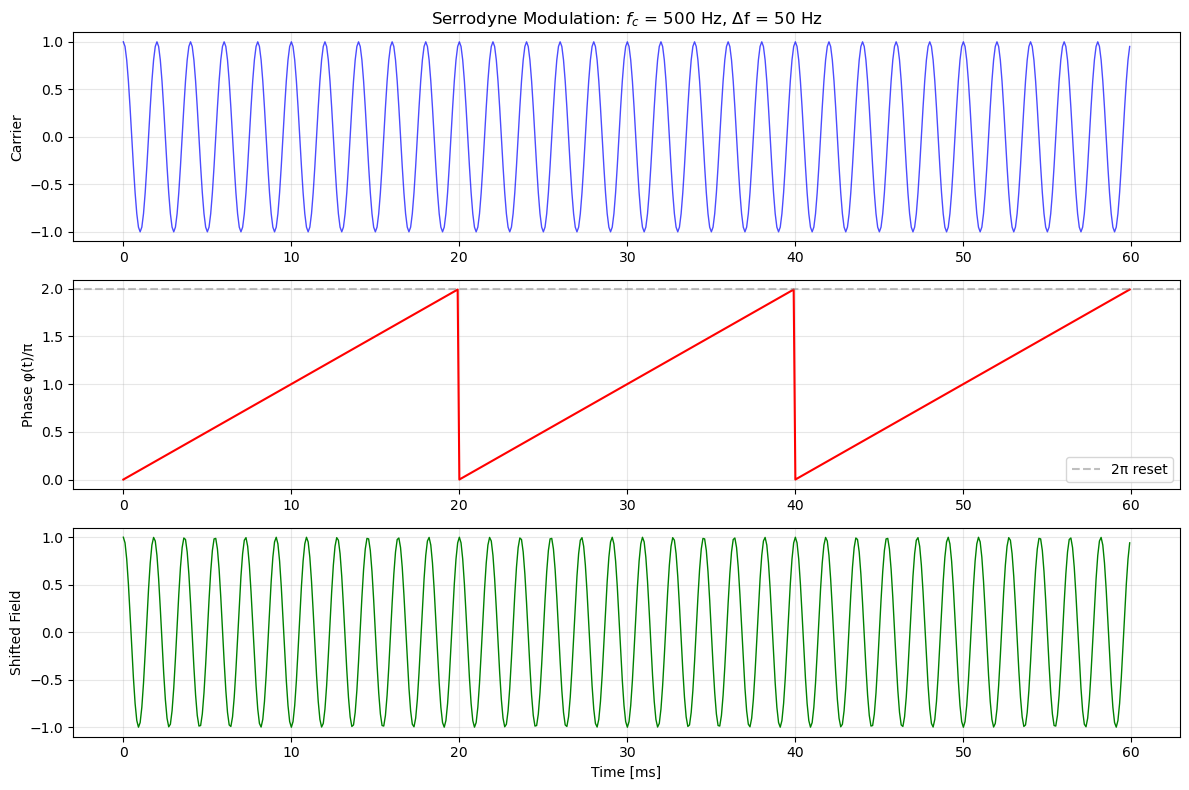

Original carrier: 500 Hz
Expected shifted frequency: 550 Hz
Peak: -550.00 Hz, Magnitude: 0.5000


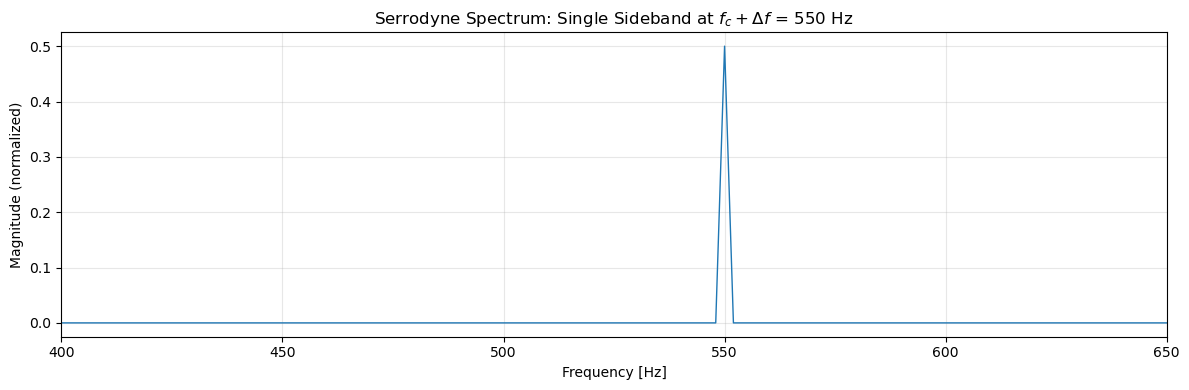

In [79]:
# Serrodyne modulation demonstration
fs = 10000          # Sampling rate [Hz]
duration = 0.5      # Duration [s]
N = int(fs * duration)
t = np.arange(N) / fs

# Signal parameters
f_c = 500           # Carrier frequency [Hz]
delta_f = 50        # Desired frequency shift [Hz] = sawtooth frequency
phi_max = 2*np.pi   # Phase amplitude (must be 2π for perfect serrodyne!)

# Generate sawtooth phase modulation (ranges from -π to +π, scale to 0 to 2π)
sawtooth_phase = phi_max * (sawtooth(2*np.pi*delta_f*t, width=1) + 1) / 2

# Generate signals
carrier = np.cos(2*np.pi*f_c*t)
E_serrodyne = np.cos(2*np.pi*f_c*t + sawtooth_phase)

# Time domain plot
fig, axes = plt.subplots(3, 1, figsize=(12, 8))

# Show 3 sawtooth periods
n_show = int(3/delta_f * fs)
axes[0].plot(t[:n_show]*1000, carrier[:n_show], 'b-', linewidth=1, alpha=0.7)
axes[0].set_ylabel('Carrier')
axes[0].set_title(f'Serrodyne Modulation: $f_c$ = {f_c} Hz, Δf = {delta_f} Hz')
axes[0].grid(True, alpha=0.3)

axes[1].plot(t[:n_show]*1000, sawtooth_phase[:n_show]/np.pi, 'r-', linewidth=1.5)
axes[1].set_ylabel('Phase φ(t)/π')
axes[1].axhline(y=2, color='gray', linestyle='--', alpha=0.5, label='2π reset')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

axes[2].plot(t[:n_show]*1000, E_serrodyne[:n_show], 'g-', linewidth=1)
axes[2].set_ylabel('Shifted Field')
axes[2].set_xlabel('Time [ms]')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Frequency domain - should show single peak at f_c + delta_f
print(f"Original carrier: {f_c} Hz")
print(f"Expected shifted frequency: {f_c + delta_f} Hz")
freq, mag = plot_fft(E_serrodyne, fs, 
                     title=f'Serrodyne Spectrum: Single Sideband at $f_c + Δf$ = {f_c+delta_f} Hz',
                     xlim=(f_c-100, f_c+150))

Target frequency: 10 Hz
DC component (mean): -0.001000
Signal range: -1.000 to 0.998


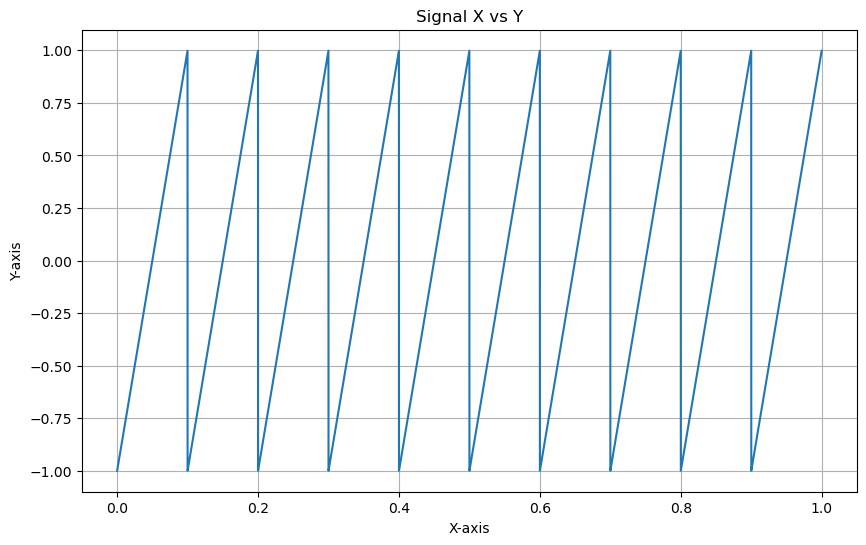

Peak: 10.00 Hz, Magnitude: 0.3183


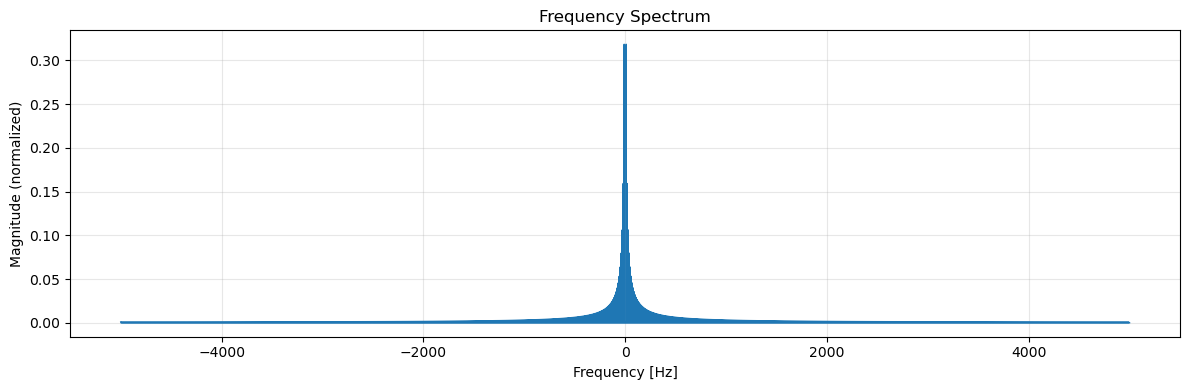

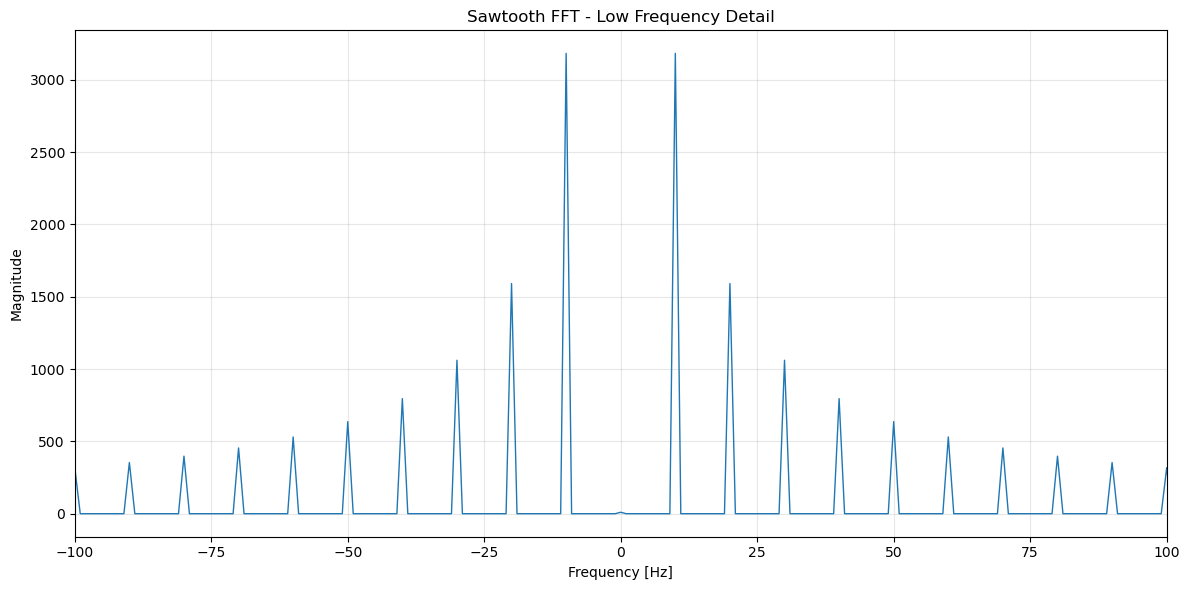

In [80]:
def analyze_sawtooth(sample_rate, target_freq_shift, duration=1):
    """
    Generate and analyze a sawtooth wave with detailed FFT analysis
    """
    t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
    wave = sawtooth(2 * np.pi * target_freq_shift * t)
    
    # Print signal characteristics
    print(f"Target frequency: {target_freq_shift} Hz")
    print(f"DC component (mean): {np.mean(wave):.6f}")
    print(f"Signal range: {np.min(wave):.3f} to {np.max(wave):.3f}")
    
    # Plot time domain
    plot_signal_x_y(t, wave)
    
    # Plot full FFT
    plot_fft(wave, sample_rate)
    
    # Plot detailed low frequency view
    plt.figure(figsize=(12, 6))
    freq_shifted = np.fft.fftshift(np.fft.fftfreq(len(wave), 1/sample_rate))
    magnitude_shifted = np.fft.fftshift(np.abs(np.fft.fft(wave)))
    plt.plot(freq_shifted, magnitude_shifted, linewidth=1)
    plt.xlim(-100, 100)  # Zoom in to see low frequency content
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Magnitude')
    plt.title('Sawtooth FFT - Low Frequency Detail')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


analyze_sawtooth(sample_rate=10_000, target_freq_shift=10)

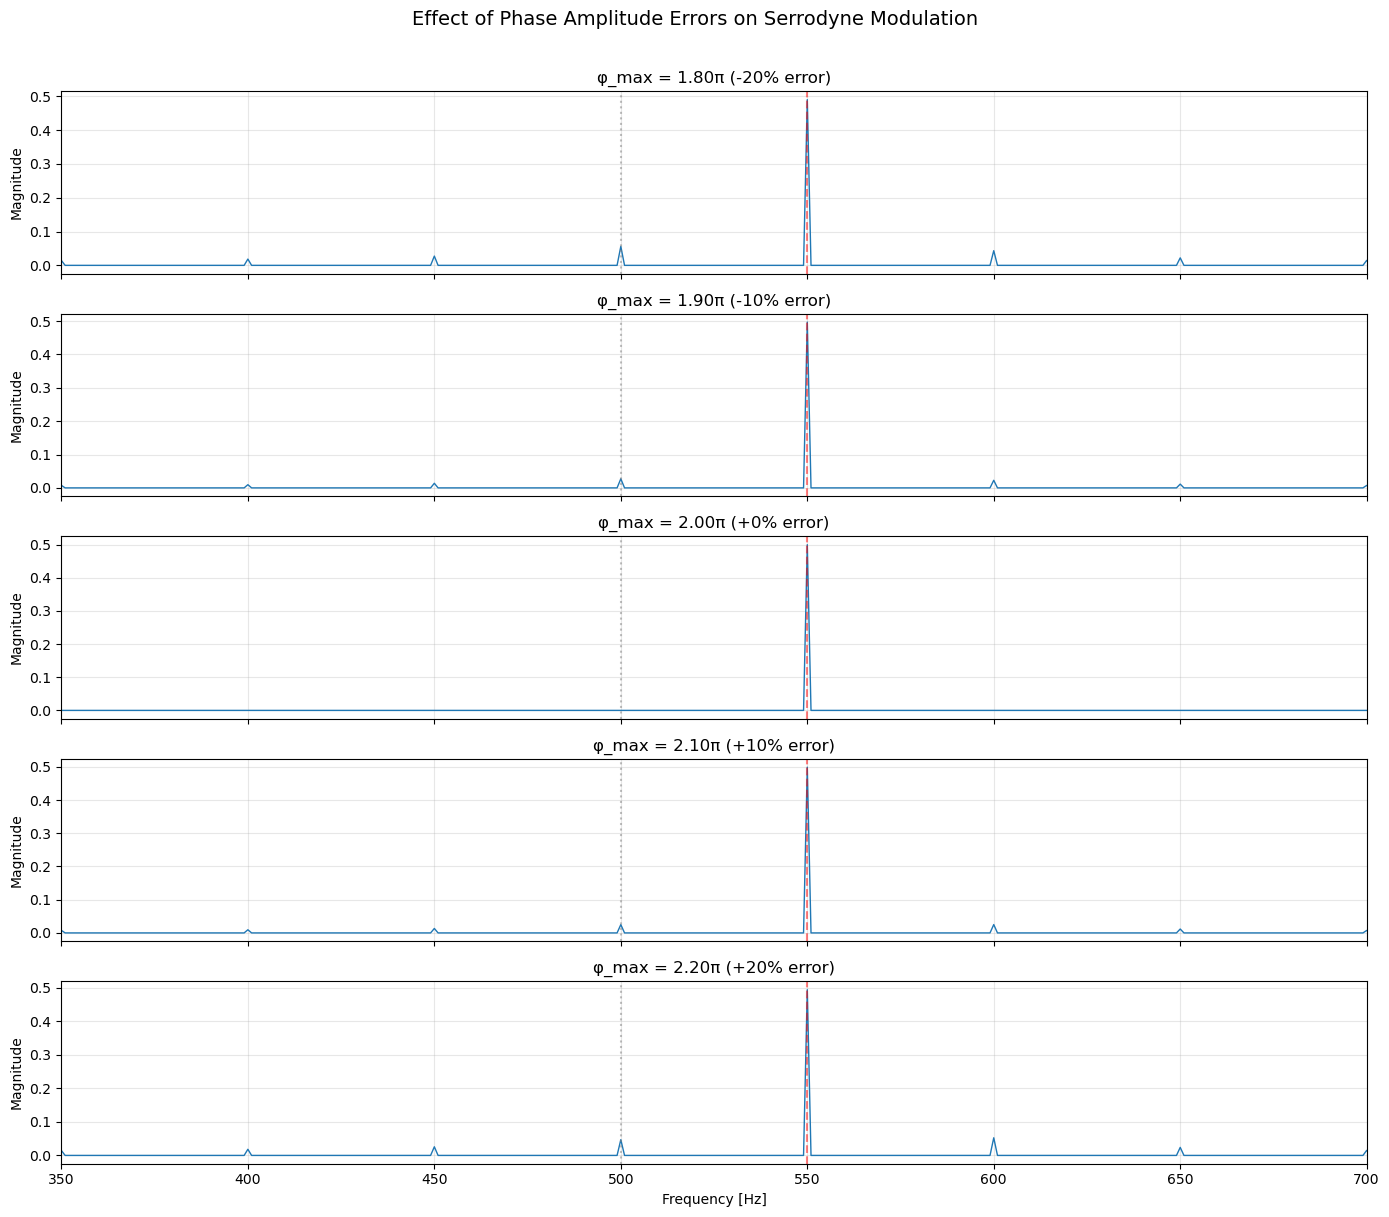

Key insight: Phase amplitude must be precisely 2π for clean single-sideband output!


In [81]:
# Effect of phase amplitude errors
fs = 10000
duration = 1
N = int(fs * duration)
t = np.arange(N) / fs

f_c = 500
delta_f = 50

# Test different phase amplitudes
phase_amplitudes = [1.8*np.pi, 1.9*np.pi, 2.0*np.pi, 2.1*np.pi, 2.2*np.pi]

fig, axes = plt.subplots(len(phase_amplitudes), 1, figsize=(14, 12), sharex=True)

for i, phi_max in enumerate(phase_amplitudes):
    sawtooth_phase = phi_max * (sawtooth(2*np.pi*delta_f*t, width=1) + 1) / 2
    E_serrodyne = np.cos(2*np.pi*f_c*t + sawtooth_phase)
    
    # FFT
    fft_vals = np.fft.fft(E_serrodyne)
    freq = np.fft.fftshift(np.fft.fftfreq(N, 1/fs))
    magnitude = np.fft.fftshift(np.abs(fft_vals)) / N
    
    axes[i].plot(freq, magnitude, linewidth=1)
    axes[i].set_xlim(f_c-150, f_c+200)
    axes[i].set_ylabel('Magnitude')
    axes[i].set_title(f'φ_max = {phi_max/np.pi:.2f}π ({(phi_max-2*np.pi)/np.pi*100:+.0f}% error)')
    axes[i].axvline(x=f_c+delta_f, color='red', linestyle='--', alpha=0.5)
    axes[i].axvline(x=f_c, color='gray', linestyle=':', alpha=0.5)
    axes[i].grid(True, alpha=0.3)

axes[-1].set_xlabel('Frequency [Hz]')
plt.suptitle('Effect of Phase Amplitude Errors on Serrodyne Modulation', fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

print("Key insight: Phase amplitude must be precisely 2π for clean single-sideband output!")

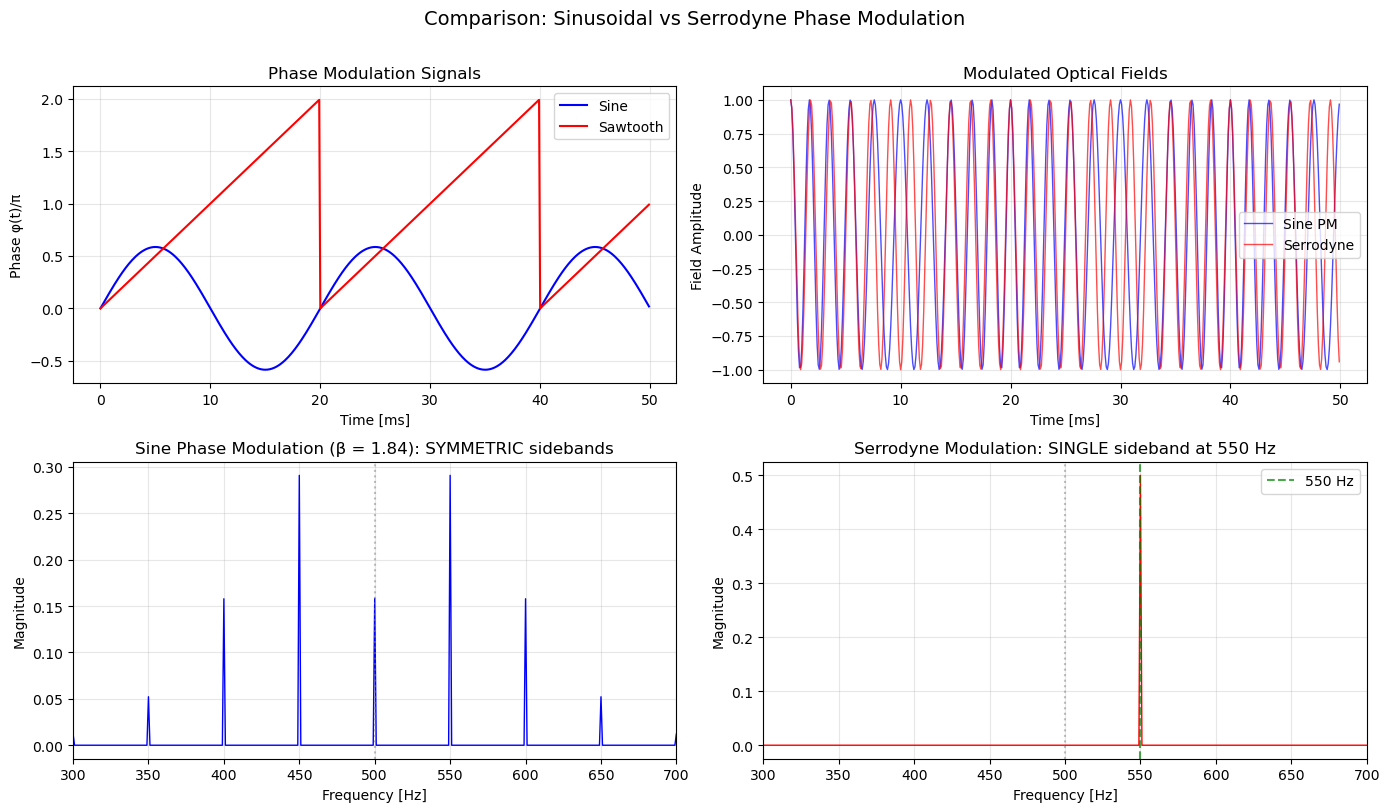

In [83]:
# Direct comparison: Sine vs Sawtooth phase modulation
fs = 10000
duration = 1
N = int(fs * duration)
t = np.arange(N) / fs

f_c = 500
f_m = 50  # Same modulation frequency for both

# Sine phase modulation (β chosen for maximum first sideband)
beta = 1.84  # First maximum of J1
sine_phase = beta * np.sin(2*np.pi*f_m*t)
E_sine = np.cos(2*np.pi*f_c*t + sine_phase)

# Sawtooth phase modulation (serrodyne)
phi_max = 2*np.pi
sawtooth_phase = phi_max * (sawtooth(2*np.pi*f_m*t, width=1) + 1) / 2
E_sawtooth = np.cos(2*np.pi*f_c*t + sawtooth_phase)

# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Time domain - phase signals
ax = axes[0, 0]
ax.plot(t[:500]*1000, sine_phase[:500]/np.pi, 'b-', label='Sine', linewidth=1.5)
ax.plot(t[:500]*1000, sawtooth_phase[:500]/np.pi, 'r-', label='Sawtooth', linewidth=1.5)
ax.set_xlabel('Time [ms]')
ax.set_ylabel('Phase φ(t)/π')
ax.set_title('Phase Modulation Signals')
ax.legend()
ax.grid(True, alpha=0.3)

# Time domain - modulated fields
ax = axes[0, 1]
ax.plot(t[:500]*1000, E_sine[:500], 'b-', alpha=0.7, label='Sine PM', linewidth=1)
ax.plot(t[:500]*1000, E_sawtooth[:500], 'r-', alpha=0.7, label='Serrodyne', linewidth=1)
ax.set_xlabel('Time [ms]')
ax.set_ylabel('Field Amplitude')
ax.set_title('Modulated Optical Fields')
ax.legend()
ax.grid(True, alpha=0.3)

# Frequency domain - Sine PM
ax = axes[1, 0]
freq = np.fft.fftshift(np.fft.fftfreq(N, 1/fs))
mag_sine = np.fft.fftshift(np.abs(np.fft.fft(E_sine))) / N
ax.plot(freq, mag_sine, 'b-', linewidth=1)
ax.set_xlim(f_c-200, f_c+200)
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Magnitude')
ax.set_title(f'Sine Phase Modulation (β = {beta:.2f}): SYMMETRIC sidebands')
ax.axvline(x=f_c, color='gray', linestyle=':', alpha=0.5)
ax.grid(True, alpha=0.3)

# Frequency domain - Serrodyne
ax = axes[1, 1]
mag_sawtooth = np.fft.fftshift(np.abs(np.fft.fft(E_sawtooth))) / N
ax.plot(freq, mag_sawtooth, 'r-', linewidth=1)
ax.set_xlim(f_c-200, f_c+200)
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Magnitude')
ax.set_title(f'Serrodyne Modulation: SINGLE sideband at {f_c+f_m} Hz')
ax.axvline(x=f_c+f_m, color='green', linestyle='--', alpha=0.7, label=f'{f_c+f_m} Hz')
ax.axvline(x=f_c, color='gray', linestyle=':', alpha=0.5)
ax.legend()
ax.grid(True, alpha=0.3)

plt.suptitle('Comparison: Sinusoidal vs Serrodyne Phase Modulation', fontsize=14, y=1.01)
plt.tight_layout()
plt.show()